In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,InceptionV3,ResNet50,VGG16,MobileNet,Xception
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report

In [ ]:
DATA_DIR = "/content/gdrive/MyDrive/UTKFace/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0})

In [ ]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [ ]:
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [ ]:
attributes = list(map(parse_filepath, files))

In [ ]:
len(files)

12490

In [ ]:
print(attributes)

[(24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'male', 'indian'), (24, 'female', 'white'), (24, 'female', 'white'), (24, 'female', 'white'), (24, 'female', 'indian'), (24, 'female', 'white'), (24, 'female', 'indian'), (24, 'female', 'asian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'female', 'indian'), (24, 'fema

In [ ]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

age gender    race                                               file
0   24   male  indian  /content/gdrive/MyDrive/UTKFace/UTKFace/24_0_3...
1   24   male  indian  /content/gdrive/MyDrive/UTKFace/UTKFace/24_0_3...
2   24   male  indian  /content/gdrive/MyDrive/UTKFace/UTKFace/24_0_3...
3   24   male  indian  /content/gdrive/MyDrive/UTKFace/UTKFace/24_0_3...
4   24   male  indian  /content/gdrive/MyDrive/UTKFace/UTKFace/24_0_3...

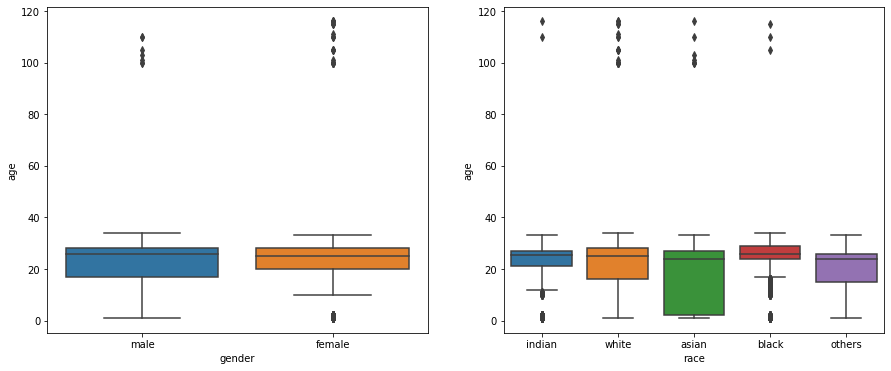

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

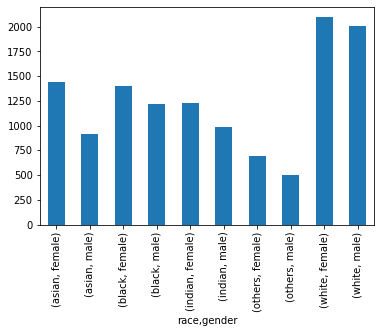

In [ ]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

In [ ]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(6120, 2623, 3747, 116)

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

# Model

# Xception

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

inputs = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = inputs
model = Xception(weights='imagenet', include_top=False, input_tensor = x)


# Freeze the pretrained weights
model.trainable = True

#for layer in model.layers:
#    layer.trainable = True

x = layers.GlobalAveragePooling2D()(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(x)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(x)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(x)
model = Model(inputs=inputs, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()


83697664/83683744 [==============================] - 3s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=30,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
95/95 [==============================] - 230s 2s/step - loss: 2.4681 - age_output_loss: 0.0190 - race_output_loss: 1.2516 - gender_output_loss: 0.5525 - age_output_mae: 0.0947 - race_output_accuracy: 0.5285 - gender_output_accuracy: 0.7189 - val_loss: 4.1392 - val_age_output_loss: 0.0097 - val_race_output_loss: 2.2841 - val_gender_output_loss: 0.6937 - val_age_output_mae: 0.0685 - val_race_output_accuracy: 0.3398 - val_gender_output_accuracy: 0.7387
Epoch 2/30
95/95 [==============================] - 212s 2s/step - loss: 1.4152 - age_output_loss: 0.0066 - race_output_loss: 0.7257 - gender_output_loss: 0.3135 - age_output_mae: 0.0616 - race_output_accuracy: 0.7377 - gender_output_accuracy: 0.8638 - val_loss: 2.6396 - val_age_output_loss: 0.0079 - val_race_output_loss: 1.2500 - val_gender_output_loss: 0.7489 - val_age_output_mae: 0.0705 - val_race_output_accuracy: 0.5918 - val_gender_output_accuracy: 0.7527
Epoch 3/30
95/95 [==============================] - 212s 2s/step - los

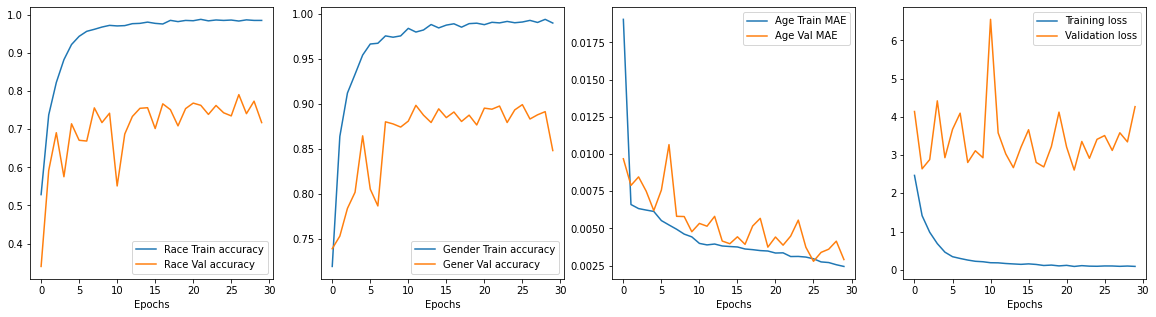

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [ ]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.71      0.98      0.82        47
           1       0.88      0.68      0.77        22
           2       0.90      0.83      0.86        23
           3       0.93      0.52      0.67        25
           4       0.27      0.27      0.27        11

    accuracy                           0.75       128
   macro avg       0.74      0.66      0.68       128
weighted avg       0.78      0.75      0.74       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        56
           1       0.93      0.79      0.86        72

    accuracy                           0.85       128
   macro avg       0.86      0.86      0.85       128
weighted avg       0.87      0.85      0.85       128



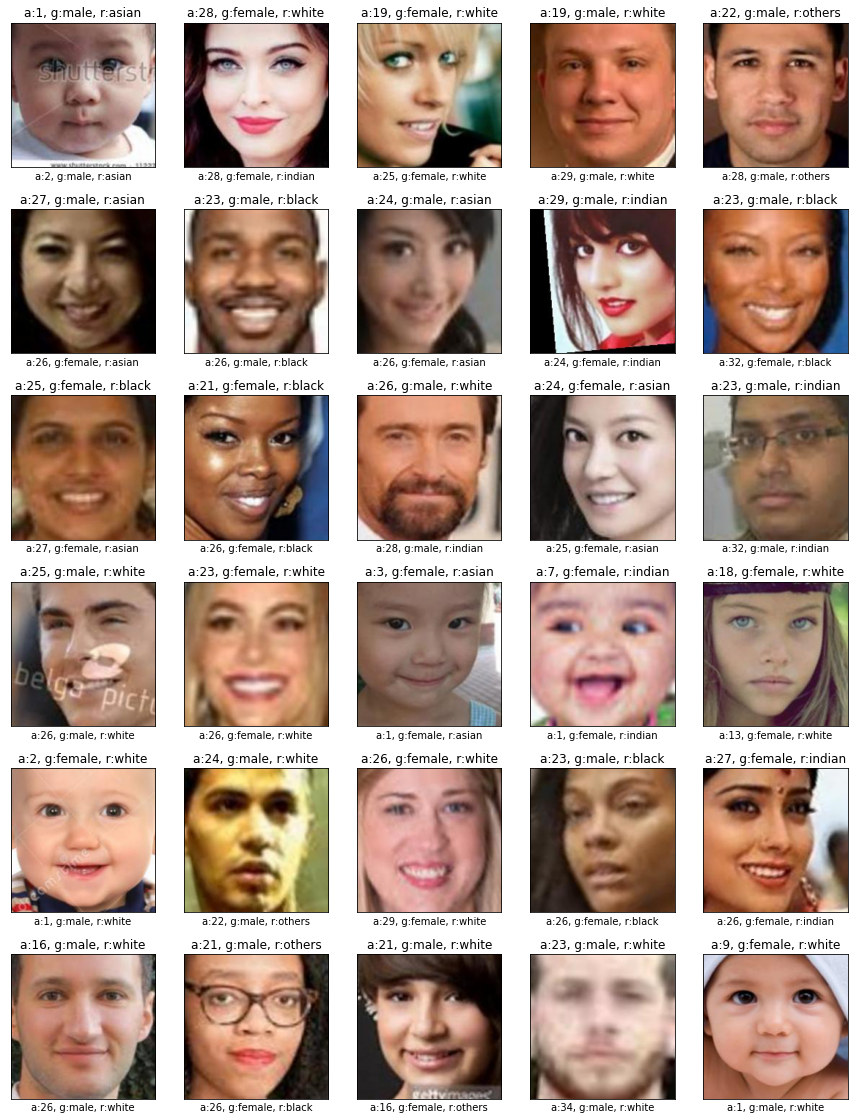

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

# ResNet50

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

inputs = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = inputs
model = ResNet50(weights='imagenet', include_top=False, input_tensor = x)


# Freeze the pretrained weights
model.trainable = True

#for layer in model.layers:
#    layer.trainable = True

x = layers.GlobalAveragePooling2D()(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(x)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(x)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(x)
model = Model(inputs=inputs, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()


94781440/94765736 [==============================] - 3s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=30,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
95/95 [==============================] - 199s 2s/step - loss: 3.9736 - age_output_loss: 0.0373 - race_output_loss: 1.9704 - gender_output_loss: 0.9434 - age_output_mae: 0.1107 - race_output_accuracy: 0.3192 - gender_output_accuracy: 0.5674 - val_loss: 20376960.0000 - val_age_output_loss: 0.6579 - val_race_output_loss: 13028361.0000 - val_gender_output_loss: 834416.6250 - val_age_output_mae: 0.8061 - val_race_output_accuracy: 0.2180 - val_gender_output_accuracy: 0.5359
Epoch 2/30
95/95 [==============================] - 159s 2s/step - loss: 3.3346 - age_output_loss: 0.0254 - race_output_loss: 1.6594 - gender_output_loss: 0.7946 - age_output_mae: 0.0954 - race_output_accuracy: 0.4327 - gender_output_accuracy: 0.6250 - val_loss: 3.0634 - val_age_output_loss: 0.0085 - val_race_output_loss: 1.5472 - val_gender_output_loss: 0.7254 - val_age_output_mae: 0.0708 - val_race_output_accuracy: 0.3281 - val_gender_output_accuracy: 0.5359
Epoch 3/30
95/95 [==============================] -

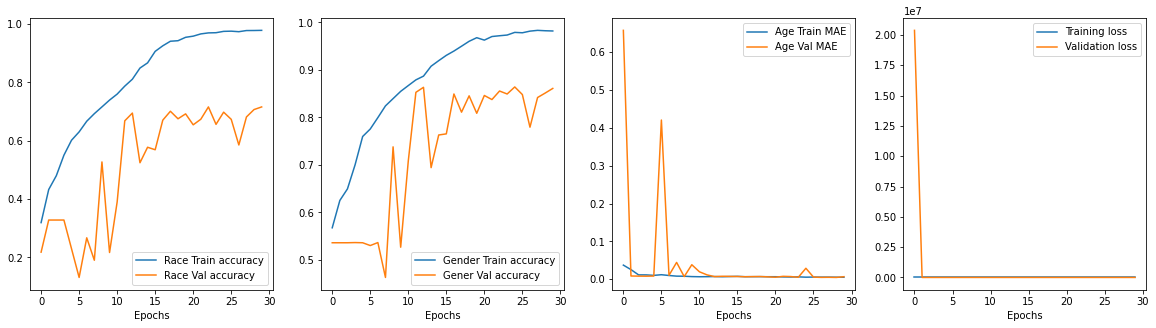

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [ ]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        47
           1       0.95      0.86      0.90        22
           2       0.75      0.52      0.62        23
           3       0.67      0.72      0.69        25
           4       0.29      0.18      0.22        11

    accuracy                           0.73       128
   macro avg       0.68      0.64      0.65       128
weighted avg       0.72      0.73      0.71       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        56
           1       0.81      0.94      0.87        72

    accuracy                           0.84       128
   macro avg       0.86      0.83      0.84       128
weighted avg       0.85      0.84      0.84       128



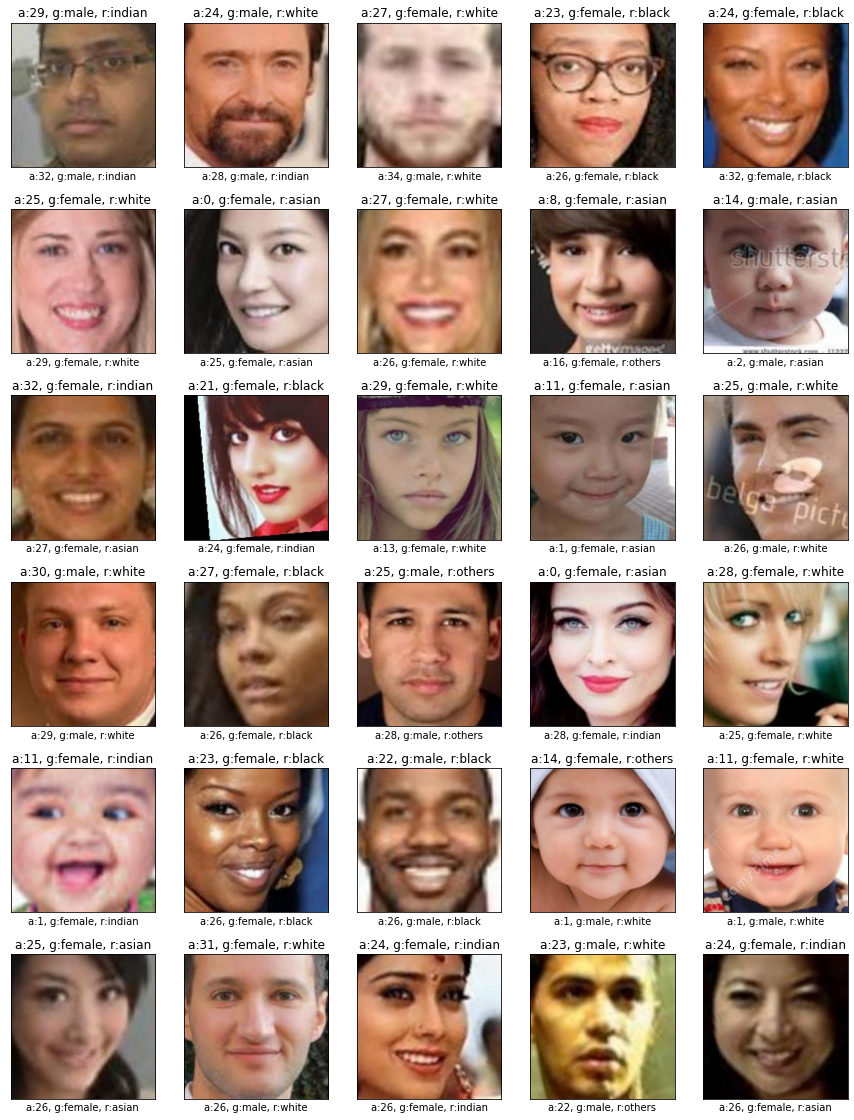

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

# MobileNet 

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

inputs = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = inputs
model = MobileNet(weights='imagenet', include_top=False, input_tensor = x)


# Freeze the pretrained weights
model.trainable = True

#for layer in model.layers:
#    layer.trainable = True

x = layers.GlobalAveragePooling2D()(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(x)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(x)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(x)
model = Model(inputs=inputs, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()


17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=30,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
95/95 [==============================] - 83s 751ms/step - loss: 2.8537 - age_output_loss: 0.0580 - race_output_loss: 1.4046 - gender_output_loss: 0.6308 - age_output_mae: 0.1777 - race_output_accuracy: 0.6008 - gender_output_accuracy: 0.7929 - val_loss: 5.1339 - val_age_output_loss: 0.0284 - val_race_output_loss: 2.3138 - val_gender_output_loss: 1.6065 - val_age_output_mae: 0.1495 - val_race_output_accuracy: 0.4863 - val_gender_output_accuracy: 0.5684
Epoch 2/30
95/95 [==============================] - 69s 729ms/step - loss: 1.6109 - age_output_loss: 0.0162 - race_output_loss: 0.8193 - gender_output_loss: 0.3495 - age_output_mae: 0.1001 - race_output_accuracy: 0.7342 - gender_output_accuracy: 0.8612 - val_loss: 2.9741 - val_age_output_loss: 0.0254 - val_race_output_loss: 1.6261 - val_gender_output_loss: 0.4840 - val_age_output_mae: 0.1355 - val_race_output_accuracy: 0.6410 - val_gender_output_accuracy: 0.8266
Epoch 3/30
95/95 [==============================] - 70s 739ms/step

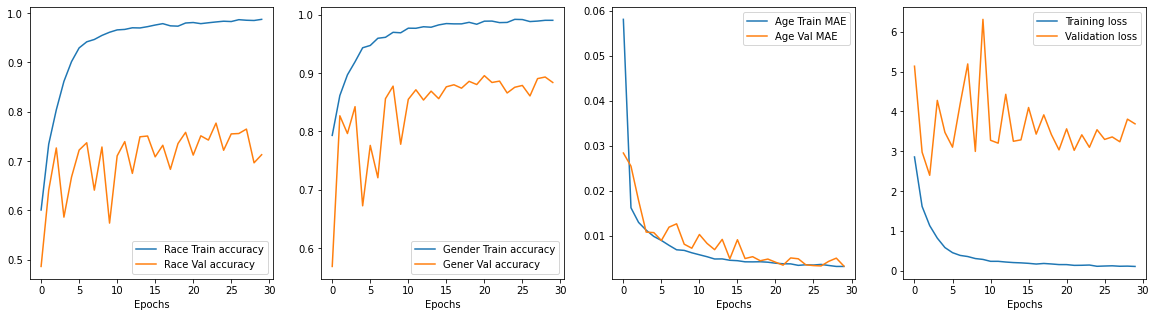

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [ ]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        47
           1       0.95      0.82      0.88        22
           2       0.75      0.52      0.62        23
           3       0.59      0.88      0.71        25
           4       0.24      0.45      0.31        11

    accuracy                           0.68       128
   macro avg       0.68      0.66      0.65       128
weighted avg       0.75      0.68      0.70       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        56
           1       0.87      0.92      0.89        72

    accuracy                           0.88       128
   macro avg       0.88      0.87      0.87       128
weighted avg       0.88      0.88      0.87       128



In [ ]:
print('Accuracy: %.3f' % accuracy_score(race_true, race_pred))

Accuracy: 0.680


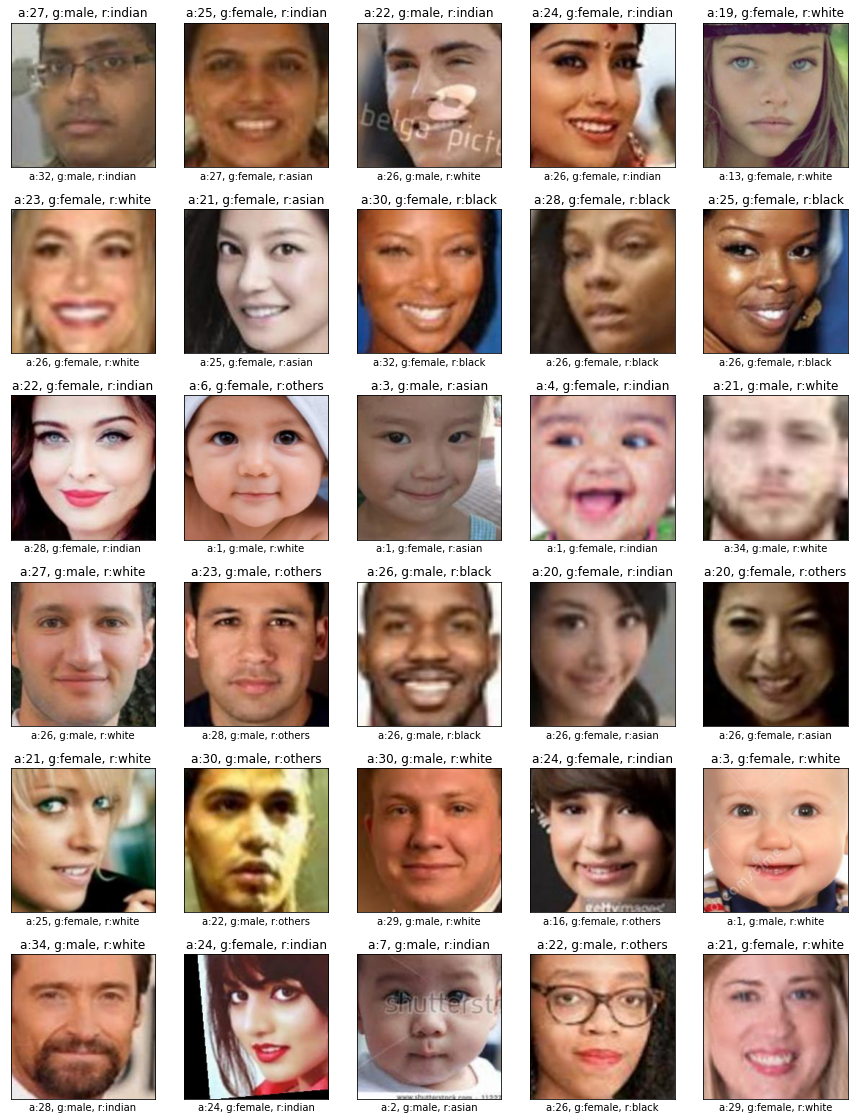

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

# Vgg16 

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

inputs = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = inputs
model = VGG16(weights='imagenet', include_top=False, input_tensor = x)


# Freeze the pretrained weights
model.trainable = True

#for layer in model.layers:
#    layer.trainable = True

x = layers.GlobalAveragePooling2D()(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(x)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(x)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(x)
model = Model(inputs=inputs, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=30,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
95/95 [==============================] - 10019s 105s/step - loss: 2.9717 - age_output_loss: 0.0303 - race_output_loss: 1.4956 - gender_output_loss: 0.6676 - age_output_mae: 0.1271 - race_output_accuracy: 0.3735 - gender_output_accuracy: 0.6095 - val_loss: 12.4105 - val_age_output_loss: 0.0158 - val_race_output_loss: 7.5709 - val_gender_output_loss: 1.0225 - val_age_output_mae: 0.1065 - val_race_output_accuracy: 0.2551 - val_gender_output_accuracy: 0.5211
Epoch 2/30
86/95 [==========================>...] - ETA: 13:48 - loss: 2.7536 - age_output_loss: 0.0105 - race_output_loss: 1.3985 - gender_output_loss: 0.6348 - age_output_mae: 0.0781 - race_output_accuracy: 0.4315 - gender_output_accuracy: 0.6430

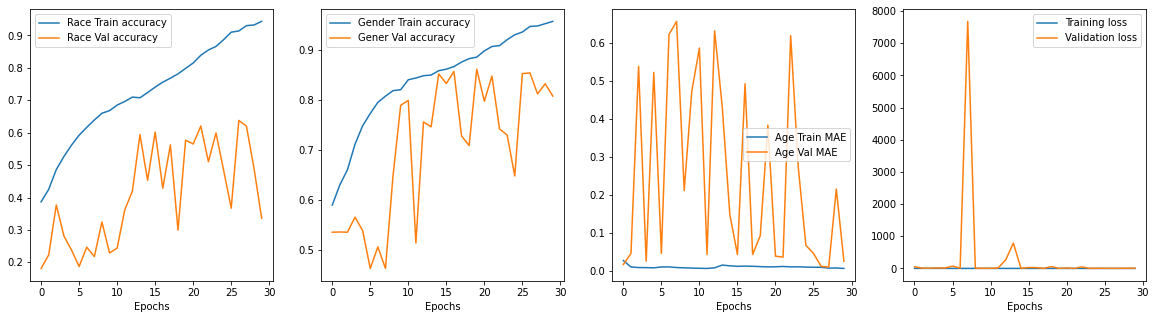

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [ ]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix
print('Confusion Matrix for race')
print(confusion_matrix(race_true, race_pred))

print('\nConfusion Matrix for gender')
print(confusion_matrix(gender_true, gender_pred))

print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Confusion Matrix for race


NameError: ignored

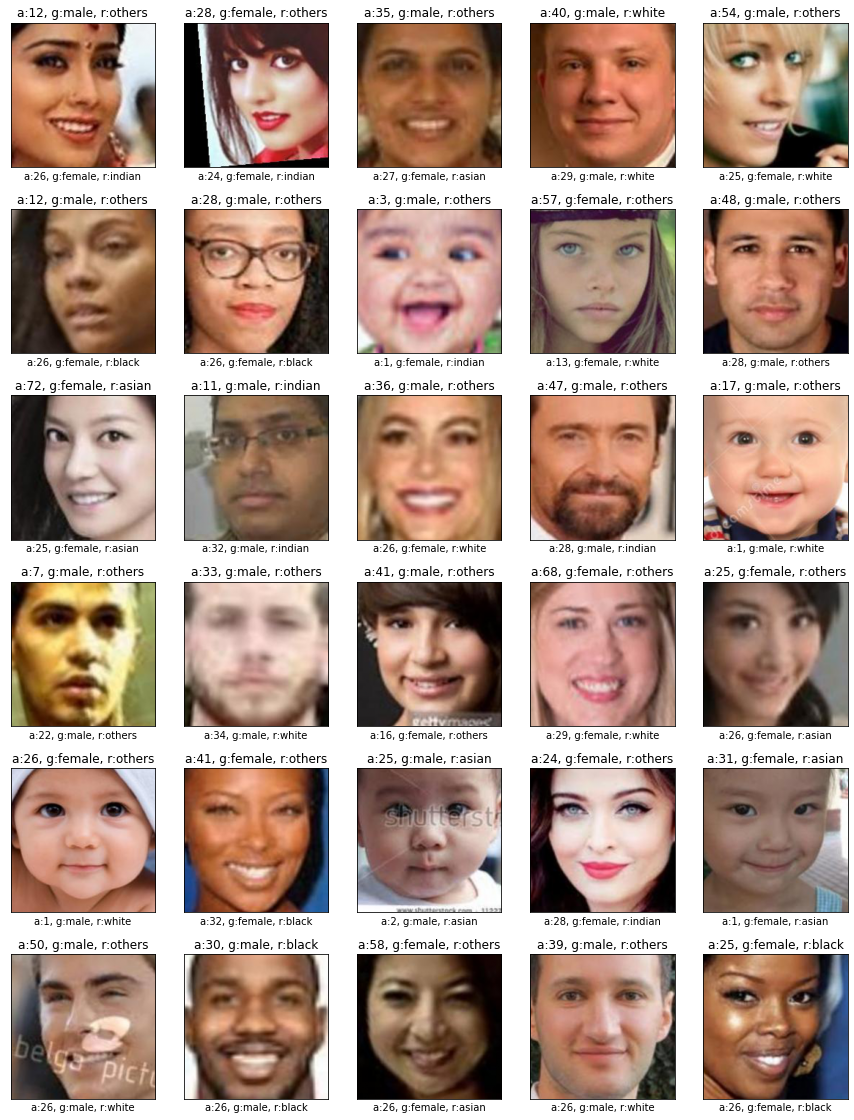

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])